<a href="https://colab.research.google.com/github/SyedAnasAli3/Masters-course-ML-projects/blob/main/Text_Classification_for_Stack_overflow_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# You need TF 1.13.1 to deploy this on AI Platform 
!pip install tensorflow==1.13.1

import tensorflow as tf 
import pandas as pd
import numpy as np 

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle

In [32]:
# Authenticate to your cloud account
from google.colab import auth
auth.authenticate_user()

In [3]:

# Download the Stack Overflow data (or replace with your own text data)
!gsutil cp 'gs://cloudml-demo-lcm/SO_ml_tags_avocado_188k_v2.csv' ./

Copying gs://cloudml-demo-lcm/SO_ml_tags_avocado_188k_v2.csv...
/ [1 files][276.7 MiB/276.7 MiB]                                                
Operation completed over 1 objects/276.7 MiB.                                    


In [4]:

data = pd.read_csv('SO_ml_tags_avocado_188k_v2.csv', names=['tags', 'original_tags', 'text'], header=0)
data = data.drop(columns=['original_tags'])
data = data.dropna()

data = shuffle(data, random_state=22)
data.head()

,tags,text
182914,"tensorflow,keras",avocado image captioning model not compiling b...
48361,pandas,return excel file from avocado with flask in f...
181447,"tensorflow,keras",validating with generator (avocado) i'm trying...
66307,pandas,avocado multiindex dataframe selecting data gi...
11283,pandas,get rightmost non-zero value position for each...


In [42]:
# Encode top tags to multi-hot
tags_split = [tags.split(',') for tags in data['tags'].values]
print(type(tags_split))

<class 'list'>


In [6]:
#
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)
num_tags = len(tags_encoded[0])
print(data['text'].values[0])
print(tag_encoder.classes_)
print(tags_encoded[0])

avocado image captioning model not compiling because of concatenate layer when mask_zero=true in a previous layer i am new to avocado and i am trying to implement a model for an image captioning project.   i am trying to reproduce the model from image captioning pre-inject architecture (the picture is taken from this paper: where to put the image in an image captioning generator) (but with a minor difference: generating a word at each time step instead of only generating a single word at the end), in which the inputs for the lstm at the first time step are the embedded cnn features. the lstm should support variable input length and in order to do this i padded all the sequences with zeros so that all of them have maxlen time steps.  the code for the model i have right now is the following:    def get_model(model_name, batch_size, maxlen, voc_size, embed_size,          cnn_feats_size, dropout_rate):      # create input layer for the cnn features     cnn_feats_input = input(shape=(cnn_fe

In [9]:

# Split our data into train and test sets
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 150559
Test size: 37640


In [11]:
# Split our labels into train and test sets
train_tags = tags_encoded[:train_size]
test_tags = tags_encoded[train_size:]

In [12]:

# Pre-processing data: create our tokenizer class
%%writefile preprocess.py

from tensorflow.keras.preprocessing import text

class TextPreprocessor(object):
  def __init__(self, vocab_size):
    self._vocab_size = vocab_size
    self._tokenizer = None
  
  def create_tokenizer(self, text_list):
    tokenizer = text.Tokenizer(num_words=self._vocab_size)
    tokenizer.fit_on_texts(text_list)
    self._tokenizer = tokenizer

  def transform_text(self, text_list):
    text_matrix = self._tokenizer.texts_to_matrix(text_list)
    return text_matrix

Writing preprocess.py


In [13]:
# Creating a vocabulary from training corpus(collection of texts). This will take time as it uses the bag size of 400 for all sentences.
from preprocess import TextPreprocessor

VOCAB_SIZE=400 # This is a hyperparameter, try out different values for your dataset

train_qs = data['text'].values[:train_size]
test_qs = data['text'].values[train_size:]

processor = TextPreprocessor(VOCAB_SIZE)
processor.create_tokenizer(train_qs)

body_train = processor.transform_text(train_qs)
body_test = processor.transform_text(test_qs)

In [14]:
# Preview the first input from our training data
print(len(body_train[0]))
print(body_train[0])

400
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0

In [15]:

# Save the processor state of the tokenizer using python's pickle module and saving it as serialised object.
import pickle

with open('./processor_state.pkl', 'wb') as f:
  pickle.dump(processor, f)

In [16]:
def create_model(vocab_size, num_tags):
  
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(50, input_shape=(VOCAB_SIZE,), activation='relu'))
  model.add(tf.keras.layers.Dense(25, activation='relu'))
  model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [17]:
model = create_model(VOCAB_SIZE, num_tags)
model.summary()

# Train and evaluate the model
model.fit(body_train, train_tags, epochs=3, batch_size=128, validation_split=0.1)
print('Eval loss/accuracy:{}'.format(
  model.evaluate(body_test, test_tags, batch_size=128)))

# Export the model to a file
model.save('keras_saved_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                20050     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 130       
Total params: 21,455
Trainable params: 21,455
Non-trainable params: 0
_________________________________________________________________
Train on 135503 samples, validate on 15056 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
135503/135503 [==============================] - 5s 38us/sample - loss: 0.1474 - acc: 0.9433 - val_loss: 0.1086 - val_acc: 0.9584
Epoch 2/3
135503/135503 [==============================] - 5s 35us/sample - loss: 0.1048 - 

In [18]:
# Use custom model prediction to save our model + tokenizer
%%writefile model_prediction.py
import pickle
import os
import numpy as np

class CustomModelPrediction(object):

  def __init__(self, model, processor):
    self._model = model
    self._processor = processor
  
  def predict(self, instances, **kwargs):
    preprocessed_data = self._processor.transform_text(instances)
    predictions = self._model.predict(preprocessed_data)
    return predictions.tolist()

  @classmethod
  def from_path(cls, model_dir):
    import tensorflow.keras as keras
    model = keras.models.load_model(
      os.path.join(model_dir,'keras_saved_model.h5'))
    with open(os.path.join(model_dir, 'processor_state.pkl'), 'rb') as f:
      processor = pickle.load(f)

    return cls(model, processor)

Writing model_prediction.py


In [19]:
#sample test question text
test_requests = [
  "How to preprocess strings in Keras models Lambda layer? I have the problem that the value passed on to the Lambda layer (at compile time) is a placeholder generated by keras (without values). When the model is compiled, the .eval () method throws the error: You must feed a value for placeholder tensor 'input_1' with dtype string and shape [?, 1] def text_preprocess(x): strings = tf.keras.backend.eval(x) vectors = [] for string in strings: vector = string_to_one_hot(string.decode('utf-8')) vectors.append(vector) vectorTensor = tf.constant(np.array(vectors),dtype=tf.float32) return vectorTensor input_text = Input(shape=(1,), dtype=tf.string) embedding = Lambda(text_preprocess)(input_text) dense = Dense(256, activation='relu')(embedding) outputs = Dense(2, activation='softmax')(dense) model = Model(inputs=[input_text], outputs=outputs) model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) model.summary() model.save('test.h5') If I pass a string array into the input layer statically, I can compile the model, but I get the same error if I want to convert the model to tflite. #I replaced this line: input_text = Input(shape=(1,), dtype=tf.string) #by this lines: test = tf.constant(['Hello', 'World']) input_text = Input(shape=(1,), dtype=tf.string, tensor=test) #but calling this ... converter = TFLiteConverter.from_keras_model_file('string_test.h5') tfmodel = converter.convert() #... still leads to this error: InvalidArgumentError: You must feed a value for placeholder tensor 'input_3' with dtype string and shape [2] [[{{node input_3}}]] ",
  "Change the bar item name in Pandas I have a test excel file like: df = pd.DataFrame({'name':list('abcdefg'), 'age':[10,20,5,23,58,4,6]}) print (df) name  age 0    a   10 1    b   20 2    c    5 3    d   23 4    e   58 5    f    4 6    g    6 I use Pandas and matplotlib to read and plot it: import pandas as pd import numpy as np import matplotlib.pyplot as plt import os excel_file = 'test.xlsx' df = pd.read_excel(excel_file, sheet_name=0) df.plot(kind='bar') plt.show() the result shows: enter image description here it use index number as item name, how can I change it to the name, which stored in column name?"
]

In [27]:
from model_prediction import CustomModelPrediction

# classifier = CustomModelPrediction.from_path('.')
results = CustomModelPrediction.from_path('.').predict(test_requests)
print(results)

for i in range(len(results)):
  print('Predicted labels:')
  for idx,val in enumerate(results[i]):
    if val > 0.7:
      print(tag_encoder.classes_[idx])
  print('\n')

AttributeError: ignored

In [37]:

!pip install shap
!pip install colored

     |████████████████████████████████| 356 kB 5.0 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491648 sha256=d2eba1bb291e2cd2b3682661b4b31308a48955e2d52c8864c99ca9a7e0e28631
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
     |████████████████████████████████| 56 kB 2.2 MB/s 
  Created wheel for colored: filename=colored-1.4.2-py3-none-any.whl size=14023 sha256=bc7092f6564b28decb312693a1186a9b9ddf1a8bd86f9ad4b5425b39abd4131a
  Stored in directory: /root/.cache/pip/wheels/5f/e1/fb/d0e85a8383ff58962319bb81c46e398fa1f4bb9e1feb0f81c4
Successfully built colored


In [38]:

import shap
attrib_data = body_train[:200]
explainer = shap.DeepExplainer(model, attrib_data)

num_explanations = 25
shap_vals = explainer.shap_values(body_test[:num_explanations])

In [39]:
words = processor._tokenizer.word_index

In [40]:
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)

word_lookup = [''] + word_lookup
print(word_lookup[:100])

['', '0', 'the', 'avocado', 'i', '1', 'to', 'a', 'in', '2', 'and', 'is', 'of', 'for', '3', 'x', 'data', 'this', 'with', 'df', 'as', '5', 'it', 'import', '4', 'from', 'gt', 'y', 'that', 'have', 'model', 'dataframe', 'file', 'self', 'but', '00', "'", 'my', 'on', 'np', '10', 'train', 'how', 'python', 'if', 'not', 'get', '7', 'line', '6', '01', 'be', 'like', 'lt', 'using', 'c', 'nan', 'am', 'column', 'py', 'name', 'code', 'input', 'index', 'values', 'can', 'size', 'do', 'plot', 'print', 'columns', 'b', 'so', 'value', 'lib', 'shape', 'set', '8', 'test', 'want', 'error', 'are', 'output', 'an', 'true', 'packages', '12', 'use', 'time', 'n', 'batch', 'return', 'or', 'add', 'by', 'def', 'would', 'list', 'when', '9']


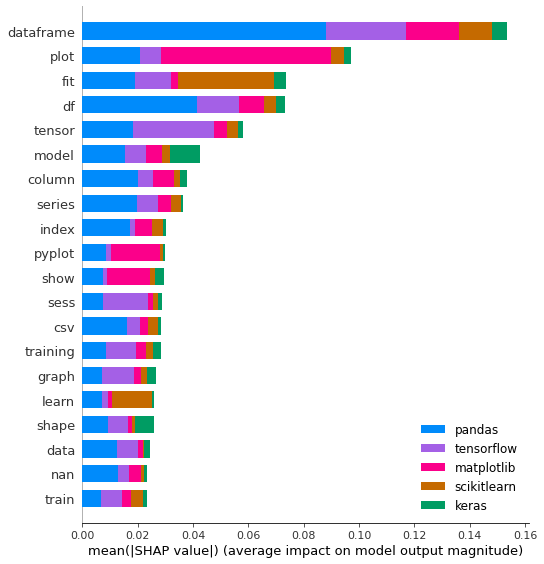

In [41]:
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=tag_encoder.classes_)